In [2]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sb
import matplotlib.patches as mpatches
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../code/')
from ldaSingleCell import VariationalLDA
from scipy import spatial

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
metaData = pd.read_csv("/data/Alex/PIC_seq_data/GSE135382_metadata2.txt",sep="\t")

In [4]:
metaData.head()

,well,amplifaction_batch,sequencing_batch,tissue,sorting_scheme,treatment,timepoint,replicate,well_coordinates,Pool_barcode,Cell_barcode,Number_of_cells
0,WMC1016609,AB6032,SB304,in vitro,TCRb+ CD11c+,Co-culture,20h,2,A1,GATGCTCA,CTATTCG,1
1,WMC1016610,AB6032,SB304,in vitro,TCRb+ CD11c+,Co-culture,20h,2,C1,GATGCTCA,ACTCAGG,1
2,WMC1016611,AB6032,SB304,in vitro,TCRb+ CD11c+,Co-culture,20h,2,E1,GATGCTCA,ACACGTG,1
3,WMC1016612,AB6032,SB304,in vitro,TCRb+ CD11c+,Co-culture,20h,2,G1,GATGCTCA,TCTTCGA,1
4,WMC1016613,AB6032,SB304,in vitro,TCRb+ CD11c+,Co-culture,20h,2,I1,GATGCTCA,AGCACTG,1


In [5]:
files_tcells = np.unique(metaData[(metaData['sorting_scheme']=='TCRb+')
                   & (metaData['treatment']=='Mono-culture') & (metaData['timepoint'].isin(["3h","20h","48h"]))]['amplifaction_batch'])

files_tcells

array(['AB6039', 'AB6040', 'AB6199', 'AB6200', 'AB6211', 'AB6220',
       'AB6221'], dtype=object)

In [6]:
#creating a merged matrix of all DCs: 
files_dcs = np.unique(metaData[(metaData['sorting_scheme']=='CD11c+')
                   & (metaData['treatment']=='Mono-culture') & (metaData['timepoint'].isin(["3h","20h","48h"]))]['amplifaction_batch'])

files_dcs

array(['AB6037', 'AB6038', 'AB6197', 'AB6198', 'AB6212', 'AB6213',
       'AB6222', 'AB6223'], dtype=object)

In [7]:
def concatData(fileIds):
    path  = "/data/Alex/PIC_seq_data/"
    files = []
    for a in fileIds: 
        filename = glob.glob(path+"*_" +a+ ".txt")
        files.append(filename[0])
    df_from_each_file = (pd.read_csv(f,sep='\t',index_col=0) for f in files)
    concatenated_df   = pd.concat(df_from_each_file, axis=1)
    return concatenated_df

In [8]:
dcs = concatData(files_dcs)

In [9]:
dcs.shape

(52634, 3072)

In [10]:
tcells = concatData(files_tcells)

In [11]:
tcells.shape

(52634, 2688)

In [12]:
all_mono = pd.concat([dcs,tcells],axis = 1)

In [13]:
all_mono.shape

(52634, 5760)

In [14]:
tcells = tcells.loc[all_mono[all_mono.astype(bool).sum(axis=1)>5].index]
dcs = dcs.loc[all_mono[all_mono.astype(bool).sum(axis=1)>5].index]

In [15]:
tcells_sample = tcells.T.sample(n=200, random_state=1)

In [16]:
dc_sample = dcs.T.sample(n=200, random_state=1)

In [17]:
all_samples = pd.concat([tcells_sample.T,dc_sample.T],axis = 1)

In [18]:
all_samples.shape

(13662, 400)

In [19]:
doublets_5050 = (tcells_sample.values+dc_sample.values)/2

In [20]:
up_regulate = ["Sell","Mif","Bcl2l1","Cd40","Myc","Ncl","Cst3","Ly6a","Ctla4","Ccl22", "Cd69","Fscn1","Dll4","Lgals1"]

In [21]:
singleCellLDA = VariationalLDA(K = 50,alpha = 1,eta=0.005,update_alpha=True)

In [22]:
singleCellLDA.load_data_sc(all_samples)

Edited


In [19]:
singleCellLDA.run_vb(n_its = 1000,initialise=True)

In [ ]:
singleCellLDA.beta_matrix.shape

In [ ]:
betas_learned = pd.DataFrame(singleCellLDA.beta_matrix)
topic_dict = betas_learned.to_dict(orient='index')

In [ ]:
#generate synthetic
doubletsdf = pd.DataFrame(doublets_5050,columns=tcells.index)
doubletsdf = doubletsdf.round()

In [ ]:
doubletsChanged = doubletsdf.copy()

In [ ]:
doubletsChanged[up_regulate]+=10

In [ ]:
scLDA = VariationalLDA(corpus=singleCellLDA.corpus,K=30,
                       word_index=singleCellLDA.word_index,
                       alpha=1,eta=0.005,update_alpha=True, fixed_topics=topic_dict)

In [ ]:
scLDA.load_data_sc(doubletsdf.T)

In [ ]:
scLDA.run_vb(n_its=1000,initialise=True)

In [ ]:
scLDAUp = VariationalLDA(corpus=singleCellLDA.corpus,K=30,
                       word_index=singleCellLDA.word_index,
                       alpha=1,eta=0.005,update_alpha=True, fixed_topics=topic_dict)

In [ ]:
scLDAUp.load_data_sc(doubletsChanged.T)

scLDAUp.run_vb(n_its=1000,initialise=True)

In [38]:
topicWordsDoublets = pd.DataFrame(scLDA.beta_matrix,columns=tcells.index)

documentTopicsDoublets = pd.DataFrame(scLDA.get_expect_theta(),index=doubletsdf.index)

In [39]:
topicsWordsUp = pd.DataFrame(scLDAUp.beta_matrix,columns=tcells.index)
documentsTopicsUp = pd.DataFrame(scLDAUp.get_expect_theta(),index=doubletsChanged.index)

In [40]:
#some useful functions

def compute_cosSim (topicsWordsMatrix, initIndex=0):
    cos_sim = pd.DataFrame()
    numTopics = topicsWordsMatrix.shape[0]
    for k in range (initIndex,numTopics):
        results = []
        for i in range (initIndex,numTopics):
            result = 1 - spatial.distance.cosine(topicsWordsMatrix.loc[i].values,topicsWordsMatrix.loc[k].values)
            results.append(result)
        cos_sim = cos_sim.append(pd.DataFrame([results]),ignore_index=True)
    return cos_sim


def cosOldNew (topicsWordsMatrix,oldInd):
    cos_sim = pd.DataFrame()
    numTopics = topicsWordsMatrix.shape[0]
    for k in range (0,oldInd):
        results = []
        for i in range (oldInd,numTopics):
            result = 1 - spatial.distance.cosine(topicsWordsMatrix.loc[i].values,topicsWordsMatrix.loc[k].values)
            results.append(result)
        cos_sim = cos_sim.append(pd.DataFrame([results]),ignore_index=True)
    return cos_sim


def findMaxSim(cos_sim,numNew):
    new_old_map = {}
    for i in range(numNew):
        maxSim = cos_sim.loc[i].max()
        new_old_map[i] = maxSim
    return new_old_map
        
       
def findMaxSimIndex(cos_sim,numNew):
    new_old_map = {}
    for i in range(numNew):
        maxSimIndex = cos_sim.loc[i].argmax()
        new_old_map[i] = maxSimIndex
    return new_old_map


def plot_cos(topicsWordsMatrix,fileName,dpi=120):
    cos_sim = compute_cosSim(topicsWordsMatrix)
    plt.figure(figsize=(100,100))
    caxes = plt.matshow(cos_sim,cmap='viridis')
    plt.title("Cosine similarity" + "\n" + "between topics",fontsize=18)
    caxes.axes.xaxis.set_ticks_position('bottom')
    plt.xlabel("Topics Index",fontsize=15)
    plt.ylabel("Topics Index",fontsize=15)
    plt.colorbar()
    plt.savefig(fileName+".png",bbox_inches='tight',dpi=dpi)
    


<Figure size 7200x7200 with 0 Axes>

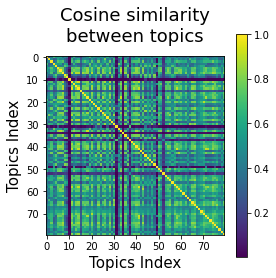

<Figure size 7200x7200 with 0 Axes>

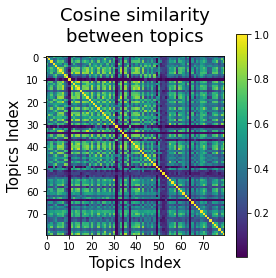

In [52]:
plot_cos(topicWordsDoublets,"doubletsCosine")

plot_cos(topicsWordsUp,"upregulatedCellsCosine")

In [98]:
#oldcos = cosOldNew(topicWordsDoublets,50)
#findMaxSim(oldcos.T,30)

In [43]:
oldcosUp = cosOldNew(topicsWordsUp,50)
findMaxSim(oldcosUp.T,30)

{0: 0.6753904527253806,
 1: 0.4416002423640424,
 2: 0.22983119398893825,
 3: 0.2578297439901692,
 4: 0.4918477798423365,
 5: 0.8752645667903536,
 6: 0.66790028032023,
 7: 0.8082894554102443,
 8: 0.5173926993038989,
 9: 0.8959732085821174,
 10: 0.7509946980853425,
 11: 0.6939488216502671,
 12: 0.4109707863176124,
 13: 0.7212765546434987,
 14: 0.05633833327723281,
 15: 0.696391089358261,
 16: 0.5836859904502277,
 17: 0.6271846309627068,
 18: 0.4755286065460145,
 19: 0.7297013363402152,
 20: 0.7984897493063153,
 21: 0.6734570353559365,
 22: 0.4576940739073604,
 23: 0.5088564169398685,
 24: 0.7368106869915778,
 25: 0.7423704917983597,
 26: 0.8325713994503688,
 27: 0.44017789963455145,
 28: 0.8366459120692404,
 29: 0.8751289524162914}

In [45]:
topicsWordsUp[up_regulate].idxmax()

Sell      52
Mif       52
Bcl2l1    52
Cd40      52
Myc       52
Ncl       52
Cst3      52
Ly6a      52
Ctla4     52
Ccl22     52
Cd69      52
Fscn1     52
Dll4      52
Lgals1    52
dtype: int64

In [99]:
#doubletsChanged.loc[100][doubletsChanged.loc[100] >5]

In [46]:
def fitsGeneCell(cellNum,geneName):
    theta = documentsTopicsUp.loc[cellNum]
    delta = np.zeros(80)
    for i in range(0,50):
        delta[i] = theta[i]/theta[0:50].sum()

    N = doubletsChanged.T[cellNum].sum()
    total = 0
    for k in range(0,80):
        total+=theta[k]*topicsWordsUp[geneName][k]
    totalFinal = total*N
    variance = totalFinal*(1-total)
    totalprim = 0
    for k in range(0,50):
        totalprim += delta[k]*topicsWordsUp[geneName][k]

    totalprimFinal = totalprim*N

    variancePrim = N*totalprim*(1-totalprim)
    return (totalFinal-3*np.sqrt(variance),totalFinal+3*np.sqrt(variance),
            totalprimFinal-3*np.sqrt(variancePrim),totalprimFinal+3*np.sqrt(variancePrim))

In [102]:
def plotGeneExpectedActual(geneName,cellIndexStart,cellIndexEnd,dpi=120):
    cellids, actualCounts, totalFlower, totalFupper, totalPrimlower,totalPrimupper = ([] for i in range(6))
#     cellids = []
#     actualCounts = []
#     totalFlower = []
#     totalFupper = []
#     totalPrimlower = []
#     totalPrimupper = []
    for i in range (cellIndexStart,cellIndexEnd):
        cellids.append(i)
        actualCounts.append(doubletsChanged.T[i][geneName])
        totalFlower.append(fitsGeneCell(i,geneName)[0])
        totalFupper.append(fitsGeneCell(i,geneName)[1])
        totalPrimlower.append(fitsGeneCell(i,geneName)[2])
        totalPrimupper.append(fitsGeneCell(i,geneName)[3])
    fig,ax1 = plt.subplots(1, 1, sharex=True, figsize=(6, 6))

    ax1.fill_between(cellids,totalFlower, totalFupper,alpha=0.2,color="green")
    ax1.fill_between(cellids,totalPrimlower, totalPrimupper,alpha=0.2,color="purple")
    ax1.scatter(cellids,actualCounts)
    total_lg = mpatches.Patch(color='green', label='E +/- 3*np.sqrt(V)')
    total_primlg = mpatches.Patch(color='purple', label='E` +/- 3*np.sqrt(V`)')
    plt.legend(handles=[total_lg,total_primlg])
    plt.xlabel("Doublet Index",fontsize=15)
    plt.ylabel("Counts",fontsize=15)
    plt.title(geneName+" Counts", fontsize=20)
    plt.savefig(geneName+"_counts.png",dpi=dpi)

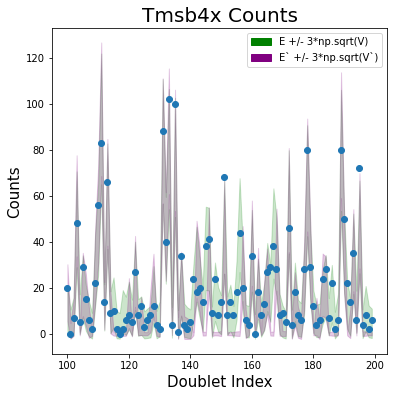

In [103]:
plotGeneExpectedActual('Tmsb4x',100,200)

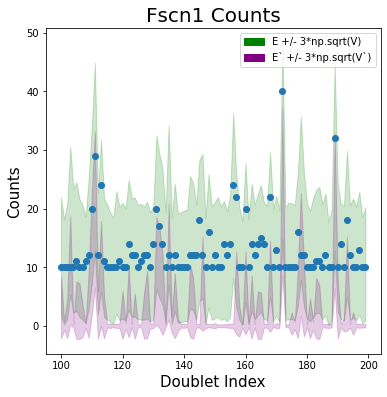

In [104]:
plotGeneExpectedActual('Fscn1',100,200)